# Sector Integration

This object takes a series of x and y coords to define a cutout, then using a user provided circle fit and cutout "centre" the [sector integration method](http://dx.doi.org/10.1118/1.597962) is implimented.

An example of using this object can be found [at the bottom of this notebook](#Example).

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Importing modules

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

import shapely.geometry as geo

from scipy.interpolate import UnivariateSpline

## The functions and modules

In [2]:
def shapely_cutout(XCoords,YCoords):
    """Returns the shapely cutout defined by the x and y coordinates.
    """
    return geo.Polygon(np.transpose((XCoords,YCoords)))

In [24]:
class sector_integration(object):
    
    def __init__(self, 
                 sectors=100, 
                 bound=25, 
                 ignoreUnexpectedIntersection=False, 
                 debug = False,
                 **kwargs):
       
    
        self.ignoreUnexpectedIntersection = ignoreUnexpectedIntersection

        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
        
        self.circle_fit = kwargs['circle_fit']
                
        self.centre = [tuple(kwargs['centre'])]
        self.centreIsWithin = self.cutout.contains(geo.Point(self.centre))
        
        self.numSectors = sectors        
        resolution = int(self.numSectors/4)
        self.boundary = geo.Point(self.centre).buffer(bound*np.sqrt(2),resolution=resolution)
        
        self.debug = debug        
        if self.debug:
            plt.plot(self.cutout.exterior.xy[0],self.cutout.exterior.xy[1])
        
        self.factor = self.factor_calculate()
        

            
    def factor_calculate(self):
        
        self.sectorMidline = [0,]*self.numSectors
        self.intersectionSet = [0,]*self.numSectors
        
        self.sectorFactors = np.zeros(self.numSectors)
        
        for i in range(self.numSectors):
            
            self.sectorMidline[i] = geo.LineString(self.centre + [self.boundary.exterior.coords[i]])      
            
            if self.debug:
                plt.plot(self.sectorMidline[i].xy[0],self.sectorMidline[i].xy[1],'g')
            
            self.intersectionSet[i] = self.sectorMidline[i].intersection(self.cutout.exterior)
            
            if type(self.intersectionSet[i]) is geo.point.Point:
                # One intersection occured
                if self.debug:
                    plt.scatter(self.intersectionSet[i].xy[0],self.intersectionSet[i].xy[1],c='g')

                if self.centreIsWithin:
                    # One intersection should only happen if the centre is within the shape
                    
                    dist = self.sectorMidline[i].project(self.intersectionSet[i])
                    
                    self.sectorFactors[i] = self.circle_fit(dist)
                    
                else:
                    
                    if self.ignoreUnexpectedIntersection:
                        self.sectorFactors[i] = np.nan
                        
                        if self.debug:
                            plt.plot(self.sectorMidline[i].xy[0],self.sectorMidline[i].xy[1],'r')
                    else:
                        raise Exception("Unexpected intersection result")
                    
            elif type(self.intersectionSet[i]) is geo.multipoint.MultiPoint:
                # Multiple intersections have occured
                
                dist = np.zeros(len(self.intersectionSet[i]))
                for j in range(len(self.intersectionSet[i])):
                    
                    point = self.intersectionSet[i][j]
                    
                    if self.debug:
                        plt.scatter(point.xy[0],point.xy[1],c='g')
                    
                    dist[j] = self.sectorMidline[i].project(point)
                
                dist = np.sort(dist)
                
                if (np.mod(len(self.intersectionSet[i]),2) == 1 ) & (self.centreIsWithin):
                    # If the centre is within the shape, number of intersections must be odd
                    
                    self.sectorFactors[i] = sum(self.circle_fit(dist[::2])) - sum(self.circle_fit(dist[1::2]))
                    
                elif (np.mod(len(self.intersectionSet[i]),2) == 0 ) & (not(self.centreIsWithin)):
                    # If the centre is outside the shape, number of intersections must be even
            
                    self.sectorFactors[i] = sum(self.circle_fit(dist[1::2])) - sum(self.circle_fit(dist[::2]))
                
                else:
                    
                    if self.ignoreUnexpectedIntersection:
                        self.sectorFactors[i] = np.nan
                        
                        if self.debug:
                            plt.plot(self.sectorMidline[i].xy[0],self.sectorMidline[i].xy[1],'r')
                    else:
                        raise Exception("Unexpected intersection result")
                    
            elif (self.sectorMidline[i].disjoint(self.cutout.exterior)) & (not(self.centreIsWithin)):
                # No intersection
                0
                
            else:
                
                if self.ignoreUnexpectedIntersection:
                    self.sectorFactors[i] = np.nan
                    
                    if self.debug:
                        plt.plot(self.sectorMidline[i].xy[0],self.sectorMidline[i].xy[1],'r')
                else:
                    raise Exception("Unexpected intersection result")
    
        
        if self.ignoreUnexpectedIntersection:            
            factor = np.nanmean(self.sectorFactors)            
        else:            
            factor = np.mean(self.sectorFactors)
        
        if self.debug:
            plt.axis("equal")  
            plt.xlim([np.min(self.cutoutXCoords) - np.ptp(self.cutoutXCoords)*0.1,
                      np.max(self.cutoutXCoords) + np.ptp(self.cutoutXCoords)*0.1])
            plt.ylim([np.min(self.cutoutYCoords) - np.ptp(self.cutoutYCoords)*0.1,
                      np.max(self.cutoutYCoords) + np.ptp(self.cutoutYCoords)*0.1])
        
        return factor

## Execute no further if being imported

Don't want to waste time running the example if this notebook is just being imported. The following cell triggers the notebook import to stop.

In [25]:
'stop nbimport'

'stop nbimport'

## Example

### Defining the circle fit from example measured factors

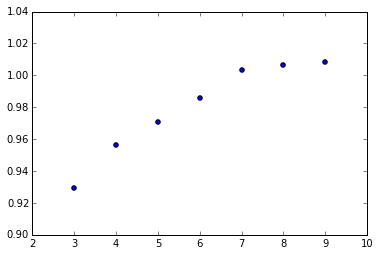

In [26]:
circle_diameter = np.array([3,4,5,6,7,8,9])
circle_factors = np.array([0.9296,0.9562,0.9705,0.9858,1.0032,1.0067,1.0084])

plt.scatter(circle_diameter, circle_factors)

In [27]:
def circle_fit(radii):
    
    circle_radii = circle_diameter/2
    
    spline = UnivariateSpline(circle_radii, circle_factors)
    results = spline(radii)
    
    outside_bounds = (radii < np.min(circle_radii)) | (radii > np.max(circle_radii))
    results[outside_bounds] = np.nan
    
    return results

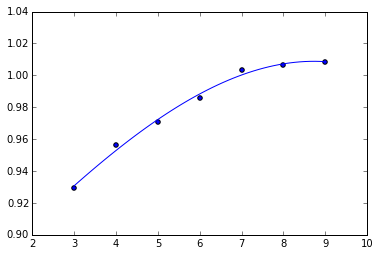

In [28]:
t = np.linspace(circle_diameter.min(),circle_diameter.max())
y = circle_fit(t/2)

plt.scatter(circle_diameter, circle_factors)
plt.plot(t,y)

### Defining the cutout

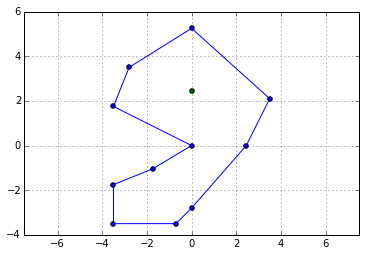

In [29]:
XCoords = np.array([-1,-1,-0.2,0,0.7,1,0,-0.8,-1,0,-0.5])*3.5
YCoords = np.array([-0.5,-1,-1,-.8,0,.6,1.5,1,0.5,0,-0.3])*3.5
centre = np.array([0,0.7])*3.5

plt.scatter(XCoords, YCoords)
plt.scatter(centre[0],centre[1],c='g')
plt.plot(np.append(XCoords, XCoords[0]), 
         np.append(YCoords, YCoords[0]))
plt.axis("equal")
plt.grid(True)

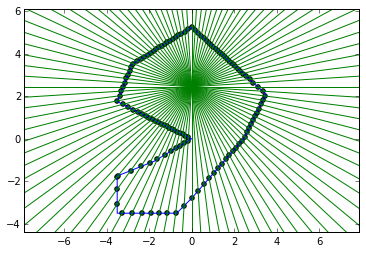

In [30]:
sectorIntegration = sector_integration(x=XCoords,
                                       y=YCoords,
                                       circle_fit=circle_fit,
                                       centre=centre,
                                       debug=True)